# Generic Engine Pipeline

The notebook provides a generic end-to-end model training pipeline for experimentation.

The notebook works by configuring the input data set and uses a disk caching method to cache function calls to speed up model training.

Unlike prior work on Project Echo, no offline pre-processing of the audio files is required (this is encapsulted in the processing pipeline within this notebook).

Author: akudilczak

Attribution: OpenAI GPT4 was utlised as a coding co-pilot to review code for correctness, provide alternative implementation suggestions and code comment enhancements.

In [2]:
########################################################################################
# library imports
########################################################################################

# disable warnings
import warnings
warnings.filterwarnings("ignore")

# generic libraries
from platform import python_version
import functools
from functools import lru_cache
import diskcache as dc
import hashlib
import numpy as np
import os
import datetime
import random
import matplotlib.pyplot as plt

# tensor flow / keras related libraries
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_hub as hub
import tensorflow_addons as tfa 
from keras.utils import dataset_utils

# image processing related libraries
import librosa

# audio processing libraries
import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# print system information
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('TensorFlow IO Version    : ', tfio.__version__)
print('Librosa Version          : ', librosa.__version__)
print('Audiomentations Version  : ', audiomentations.__version__)

ModuleNotFoundError: No module named 'diskcache'

## System Configuration

The following code sets up the pipeline with configuration options.

The key is to set the audio data directory to the root directory containing the folders with raw audio files. 

This expects the folders names to be the species names.  

In [ ]:
########################################################################################
# system constants
########################################################################################

SC = {
    'AUDIO_DATA_DIRECTORY': "/mnt/d/data/bc",
    'CACHE_DIRETORY': "/mnt/d/pipeline_cache",

    'AUDIO_CLIP_DURATION': 5, # 5 second clips
    'AUDIO_NFFT': 2000,
    'AUDIO_WINDOW': 500,
    'AUDIO_STRIDE': 200,
    'AUDIO_SAMPLE_RATE': 32000,  # int(44100/2)
    'AUDIO_MELS': 260,
    'AUDIO_FMIN': 10,
    'AUDIO_FMAX': int(32000 / 2),
    'AUDIO_TOP_DB': 80,

    'MODEL_INPUT_IMAGE_WIDTH': 260,
    'MODEL_INPUT_IMAGE_HEIGHT': 260,
    'MODEL_INPUT_IMAGE_CHANNELS': 3,

    'USE_DISK_CACHE': True,
    'SAMPLE_VARIANTS': 40,
    'CLASSIFIER_BATCH_SIZE': 16
}

: 

: 

In [ ]:
def enforce_memory_limit(mem_mb):
  # enforce memory limit on GPU

  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem_mb)])
      print(f"vram limit set to {mem_mb}MB")
    except RuntimeError as e:
      print(e)
      
# enforce max 5GB memory on GPU for this notebook if you have a small GPU
# enforce_memory_limit(5120)

: 

: 

# Disk Caching

The following code creates a disk cache.  You will need lots of space (20 GB+) if you create large melspectrograms.

The caching works by serialising a function call signature and hashing it into a key.  This key is used to store the result of the function call.

This allows the a result from the cache to be utilised instead of calling the function, which means the entire data processing pipeline can be cached if used correctly.

This works best when the function being cached is idempotent.  There may be circumstances where it doesn't matter.  Be careful with using this cache as you may get unexpected results.

In [ ]:
########################################################################################
# Create a DiskCache instance
# This cache will allow us store intermediate function results to speed up the 
# data processing pipeline
########################################################################################
if SC['USE_DISK_CACHE']:
    cache = dc.Cache(SC['CACHE_DIRETORY'], cull_limit=0, size_limit=10**9) 


########################################################################################
# a helper function to create a hash key from a function signature and arguments
########################################################################################
def create_function_key(func, *args, **kwargs):
    partial_func = functools.partial(func, *args, **kwargs)
    func_name = partial_func.func.__name__
    func_module = partial_func.func.__module__
    args_repr = repr(partial_func.args)
    kwargs_repr = repr(sorted(partial_func.keywords.items()))

    key = f"{func_module}.{func_name}:{args_repr}:{kwargs_repr}"
    # Use hashlib to create a hash of the key for shorter and consistent length
    key_hash = hashlib.sha256(key.encode()).hexdigest()

    return key, key_hash, partial_func


########################################################################################
# Execute a function and cache the result
# If already executed, retrieve function output from the cache instead
########################################################################################
def execute_cached_function(func, *args, **kwargs):
    key_string,key,partial_func = create_function_key(func, *args, **kwargs)
    # Check if the result is in the cache
    if key in cache:
        result = cache[key]
        # print(f"Result loaded from cache key: {key}")
    else:
        # If not in cache, call the slow operation and store the result in cache
        result = partial_func()
        cache[key] = result
        #print(f"New result calculated and stored in cache key: {key}")
    return result

: 

: 

# Loading the files into a Tensorflow dataset structure for model training

This initial code loads only the filenames.  The filenames are then split into train, validation and test datasets.  This is designed deliberately this way to conserve runtime memory.

Subsequent downstream loading of the file content occurs as part of the data pipeline transformation 'map' function.  See below.

In [ ]:
########################################################################################
# these helper functions load the audio data into a 'dataset' using only paths
# just dealing with paths at this early stage means the entire dataset can be shuffled in
# memory and split before loading the actual audio data into memory
########################################################################################
def paths_and_labels_to_dataset(image_paths, labels, num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    zipped_path_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return zipped_path_ds

def create_datasets(audio_files, train_split=0.7, val_split=0.2):
    file_paths, labels, class_names = dataset_utils.index_directory(
            audio_files,
            labels="inferred",
            formats=('.ogg','.mp3','.wav','.flac'),
            class_names=None,
            shuffle=True,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=file_paths,
        labels=labels,
        num_classes=len(class_names))
    
    # Calculate the size of the dataset
    dataset_size = len(dataset)
    
    # Calculate the number of elements for each dataset split
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size).take(test_size)
    
    return train_ds, val_ds, test_ds, class_names

: 

: 

In [ ]:
# create the dataset
train_ds, val_ds, test_ds, class_names = create_datasets(SC['AUDIO_DATA_DIRECTORY'],train_split=0.8, val_split=0.19)
print("Class names: ", class_names)
print(f"Training   dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test       dataset length: {len(test_ds)}")

: 

: 

In [ ]:
# show what the pipeline looks like at this stage
for item in train_ds.take(10):
    print(item)

: 

: 

In [ ]:
def try_decode_audio(file_contents, decode_func):
    try:
        return decode_func(input=file_contents)
    except Exception as e:
        # print(f"An error occurred while decoding the audio file using {decode_func.__name__}:")
        # print(str(e))
        return None

# enable this cache if using large audio files, and lots of available RAM
@lru_cache(maxsize=len(train_ds))
def load_and_decode_file(path):
    
    # read the file data
    file_contents=tf.io.read_file(path)
    
    tmp_audio_t = None

    # attempt to decode each known format
    if path.lower().endswith(b'.flac'):
        if tmp_audio_t is None:
            tmp_audio_t = try_decode_audio(file_contents, lambda input: tfio.audio.decode_flac(input, dtype=tf.uint8))
        if tmp_audio_t is None:
            tmp_audio_t = try_decode_audio(file_contents, lambda input: tfio.audio.decode_flac(input, dtype=tf.int16))
        if tmp_audio_t is None:
            tmp_audio_t = try_decode_audio(file_contents, lambda input: tfio.audio.decode_flac(input, dtype=tf.int32))              
    
    if path.lower().endswith(b'.ogg'):
        if tmp_audio_t is None:
            tmp_audio_t = try_decode_audio(file_contents, tfio.audio.decode_vorbis)
            
    if path.lower().endswith(b'.mp3'):        
        if tmp_audio_t is None:
            tmp_audio_t = try_decode_audio(file_contents, tfio.audio.decode_mp3)
            
    if path.lower().endswith(b'.wav'):          
        if tmp_audio_t is None:
            tmp_audio_t = try_decode_audio(file_contents, lambda input: tfio.audio.decode_wav(input, dtype=tf.uint8))        
        if tmp_audio_t is None:
            tmp_audio_t = try_decode_audio(file_contents, lambda input: tfio.audio.decode_wav(input, dtype=tf.int16))
        if tmp_audio_t is None:
            tmp_audio_t = try_decode_audio(file_contents, lambda input: tfio.audio.decode_wav(input, dtype=tf.int32))
        if tmp_audio_t is None:
            tmp_audio_t = try_decode_audio(file_contents, lambda input: tfio.audio.decode_wav(input, dtype=tf.float32))

    # cast and keep right channel only
    tmp_audio_t = tf.cast(tmp_audio_t, tf.float32)[:,-1]
    
    # resample the sample rate
    tmp_audio_t = tfio.audio.resample(tmp_audio_t, tfio.audio.AudioIOTensor(path)._rate.numpy(), SC['AUDIO_SAMPLE_RATE'])
    
    # convert to numpy for caching purposes
    tmp_audio_t = tmp_audio_t.numpy()
    
    assert(tmp_audio_t is not None)
    assert(isinstance(tmp_audio_t, np.ndarray))
    
    return tmp_audio_t

: 

: 

# Sampling the audio files

The function loads and decodes an audio file from the given path, calculates the audio file's duration in seconds, and then extracts a random subsection of the specified duration (in seconds) from the audio. If the audio duration is shorter than the specified duration, the function pads the subsection with silence to meet the required length. The resulting subsection is returned as a tensor.

In [ ]:
def load_random_subsection(path, duration_secs):
    
    # load file and decode audio format
    tmp_audio_t = load_and_decode_file(path.numpy())

    # Determine the audio file's duration in seconds
    audio_duration_secs = tf.shape(tmp_audio_t)[0] / SC['AUDIO_SAMPLE_RATE']
    
    if audio_duration_secs>duration_secs:
    
        # Calculate the starting point of the 5-second subsection
        max_start = tf.cast(audio_duration_secs - duration_secs, tf.float32)
        start_time_secs = tf.random.uniform((), 0.0, max_start, dtype=tf.float32)
        
        start_index = tf.cast(start_time_secs * SC['AUDIO_SAMPLE_RATE'], dtype=tf.int32)
  
        # Load the 5-second subsection
        end_index = tf.cast(start_index + tf.cast(duration_secs, tf.int32) * SC['AUDIO_SAMPLE_RATE'], tf.int32)
        
        subsection = tmp_audio_t[start_index : end_index]
    
    else:
        # Pad the subsection with silence if it's shorter than 5 seconds
        padding_length = duration_secs * SC['AUDIO_SAMPLE_RATE'] - tf.shape(tmp_audio_t)[0]
        padding = tf.zeros([padding_length], dtype=tmp_audio_t.dtype)
        subsection = tf.concat([tmp_audio_t, padding], axis=0).numpy()

    return subsection

: 

: 

# Audio augmentations

The following code applies a sequence of augmentations to the audio signal.

A probability of applying the augmentation is used to ensure the augmentation isn't applied every sample.

This means there will be some samples that go straight through with no augmentations and a small probability that in fact all augmentations will be applied.

In [ ]:
# Audio augmentation pipeline
# See https://github.com/iver56/audiomentations for more options
audio_augmentations = Compose([
    # Add Gaussian noise with a random amplitude to the audio
    # This can help the model generalize to real-world scenarios where noise is present
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.2),

    # Time-stretch the audio without changing its pitch
    # This can help the model become invariant to small changes in the speed of the audio
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.2),

    # Shift the pitch of the audio within a range of semitones
    # This can help the model generalize to variations in pitch that may occur in real-world scenarios
    PitchShift(min_semitones=-4, max_semitones=4, p=0.2),

    # Shift the audio in time by a random fraction
    # This can help the model become invariant to the position of important features in the audio
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.2),
])

: 

: 

# Image Augmentations

After the melspectrogram pipeline is executed, a 2D image is created of the signal energy at frequence/time points.

This image is augmented by applying the function below.  In this example a random rotation of between -2 and 2 degrees is applied every time.

In [ ]:
# image augmentation pipeline
def image_augmentations(image, label):

    degrees = tf.random.uniform(shape=(1,), minval=-2, maxval=2)
    radians = degrees * 0.017453292519943295  # convert the angle in degree to radians

    image = tfa.image.rotate(image, radians, interpolation='bilinear')
    
    return image,label

: 

: 

In [ ]:
# this function takes the audio_clip and generates a melspectrogram representation
# the size of the image will always be the same as the length of audio is fixed and the
# various parameters such as AUDIO_STRIDE that impact image size are also fixed.
def dataset_melspectro_pipeline(path, label, variant, config, audio_clip):
    
    # Convert to spectrogram
    image = tfio.audio.spectrogram(
        audio_clip,
        nfft=config['AUDIO_NFFT'], 
        window=config['AUDIO_WINDOW'], 
        stride=config['AUDIO_STRIDE'])

    # Convert to melspectrogram
    image = tfio.audio.melscale(
        image, 
        rate=config['AUDIO_SAMPLE_RATE'], 
        mels=config['AUDIO_MELS'], 
        fmin=config['AUDIO_FMIN'], 
        fmax=config['AUDIO_FMAX'])
    
    # reshape into standard 3 channels to add the color channel
    image = tf.expand_dims(image, -1)
    
    # most pre-trained model classifer model expects 3 color channels
    image = tf.repeat(image, config['MODEL_INPUT_IMAGE_CHANNELS'], axis=2)
    
    # calculate the image shape and ensure it is correct
    expected_clip_samples = int(config['AUDIO_CLIP_DURATION'] * config['AUDIO_SAMPLE_RATE'] / config['AUDIO_STRIDE'])
    image = tf.ensure_shape(image, [expected_clip_samples, config['AUDIO_MELS'], config['MODEL_INPUT_IMAGE_CHANNELS']])
    
    # note here a high quality LANCZOS5 is applied to resize the image to match model image input size
    image = tf.image.resize(image, (config['MODEL_INPUT_IMAGE_WIDTH'],config['MODEL_INPUT_IMAGE_HEIGHT']), 
                            method=tf.image.ResizeMethod.LANCZOS5)

    # rescale to range [0,1]
    image = image - tf.reduce_min(image) 
    image = image / (tf.reduce_max(image)+0.0000001)
    
    return image, label

: 

: 

# Individual dataset pipelines

The dataset is split into different pipeline function as that augmentations would be applied to the training data only.

In [ ]:
def dataset_validation_pipeline(path, label, variant, config):
    # this loads a random 5 second clip of audio from the raw audio file
    audio_clip = load_random_subsection(path, duration_secs=config['AUDIO_CLIP_DURATION'])

    # Convert to spectrogram
    image, label = dataset_melspectro_pipeline(path, label, variant, config, audio_clip)
    
    return image, label

def dataset_test_pipeline(path, label, variant, config):
    # this loads a random 5 second clip of audio from the raw audio file
    audio_clip = load_random_subsection(path, duration_secs=config['AUDIO_CLIP_DURATION'])

    # Convert to spectrogram
    image, label = dataset_melspectro_pipeline(path, label, variant, config, audio_clip)
    
    return image, label

def dataset_training_pipeline(path, label, variant, config):
    # this loads a random 5 second clip of audio from the raw audio file
    # note: it also converts the sample rate to AUDIO_SAMPLE_RATE and selects the left channel only
    audio_clip = load_random_subsection(path, duration_secs=config['AUDIO_CLIP_DURATION'])
   
    # apply audio augmentation to the clip
    # note: this augmentation is NOT applied in the test and validation pipelines
    audio_clip = audio_augmentations(samples=audio_clip, sample_rate=config['AUDIO_SAMPLE_RATE'])
   
    # Convert to spectrogram
    image, label = dataset_melspectro_pipeline(path, label, variant, config, audio_clip)
    
    # apply image based augmentation to the melspectrogram
    image, label = image_augmentations(image, label)
    
    return image, label

: 

: 

In [ ]:
# Function to execute pipeline function with caching, if enabled
def dataset_cached_pipeline(pipeline_fn, path, label):
    variant = random.randrange(0, SC['SAMPLE_VARIANTS'])
    if SC['USE_DISK_CACHE']:
        return execute_cached_function(pipeline_fn, path, label, variant, SC)
    else:
        return pipeline_fn(path, label, variant, SC)

# Function to allow Python execution within the TensorFlow pipeline
def dataset_pipeline_wrapper(pipeline_fn, path, label):
    # Use a lambda function to pass two arguments to the dataset_example_pipeline function
    image, label = tf.py_function(func=lambda x, y: dataset_cached_pipeline(pipeline_fn, x, y),
                                   inp=(path, label),
                                   Tout=(tf.float32, label.dtype))

    # Set the shape of the output tensors manually
    image.set_shape([SC['MODEL_INPUT_IMAGE_WIDTH'], SC['MODEL_INPUT_IMAGE_HEIGHT'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
    label.set_shape([len(class_names),])  # Set the shape of the label tensor

    return image, label

: 

: 

In [ ]:
########################################################################################
# Create the datasets necessary for training a classification model
# Note: Using py_function seems to prevent the use of parallel calls, which slows down
# the pipeline significantly. This requires investigation of alternative ways to construct the pipeline.
########################################################################################

# Get the length of the training dataset
len_train_ds = len(train_ds)

# Create the training dataset pipeline
train_dataset = (train_ds
                 .shuffle(len_train_ds)
                 .map(functools.partial(dataset_pipeline_wrapper, dataset_training_pipeline), num_parallel_calls=1)
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 .repeat(count=1)
)

# Create the validation dataset pipeline
validation_dataset = (val_ds
                      .map(functools.partial(dataset_pipeline_wrapper, dataset_validation_pipeline), num_parallel_calls=1)
                      .batch(SC['CLASSIFIER_BATCH_SIZE'])
                      .repeat(count=1)
)

# Create the test dataset pipeline
test_dataset = (test_ds
                .map(functools.partial(dataset_pipeline_wrapper, dataset_test_pipeline), num_parallel_calls=1)
                .batch(SC['CLASSIFIER_BATCH_SIZE'])
                .repeat(count=5)
)

: 

: 

# Data Pipeline Inspection

The following shows 1 batch of training data to provide a visual guide as to whether the data pipeline is functioning as expected.

It is important to observe in the ground truth labels that the classes are random - indicating that the pipeline shuffle function is working as expected.

2023-04-25 20:44:45.665222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 sample info: (16, 260, 260, 3), 
 label info: (16, 5) 
 [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


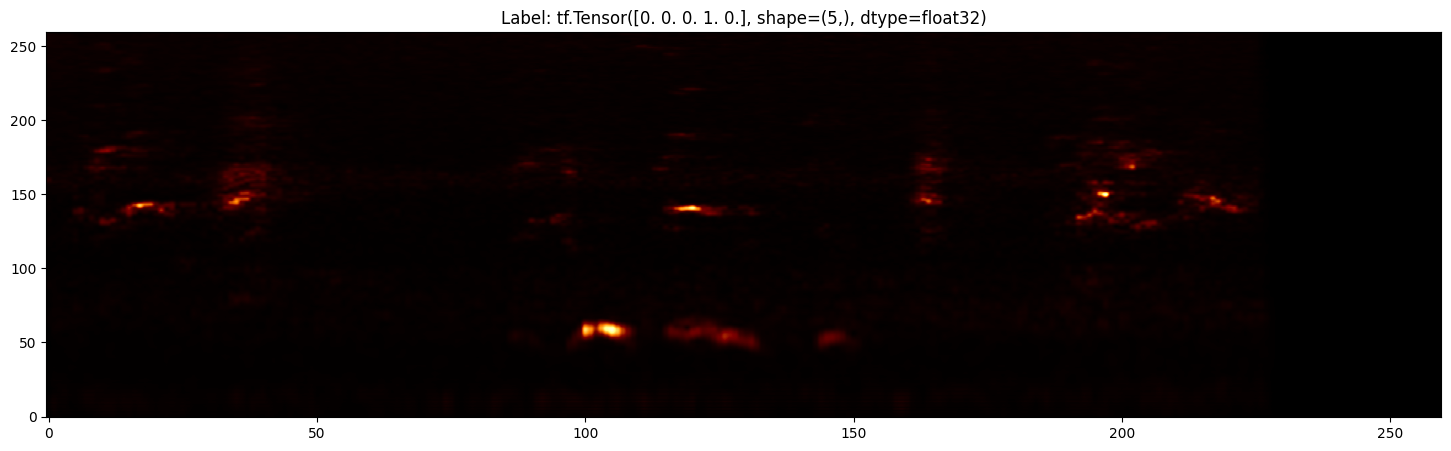

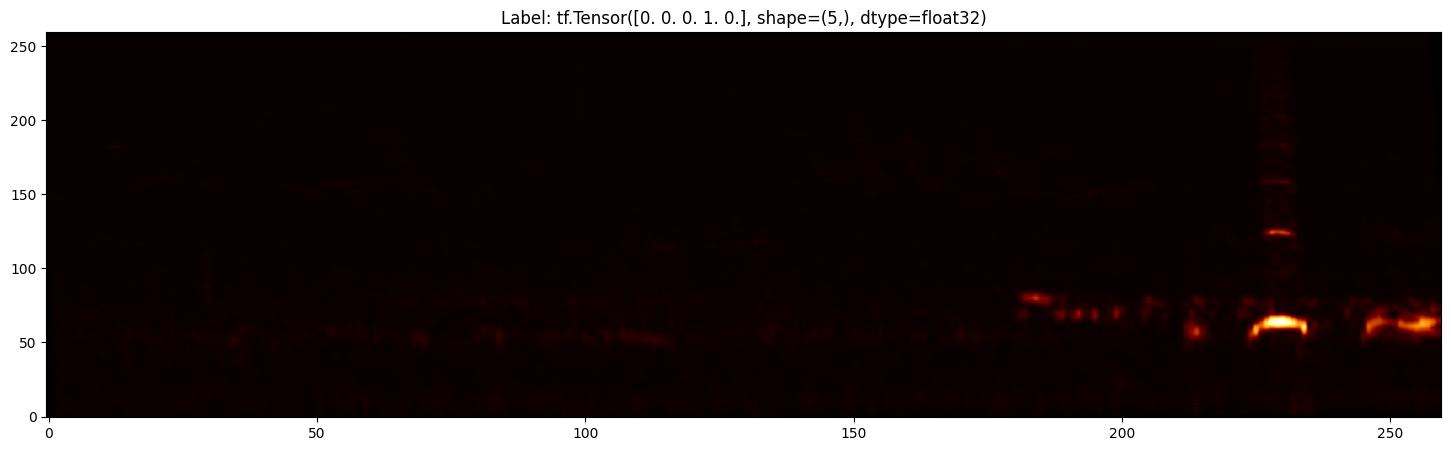

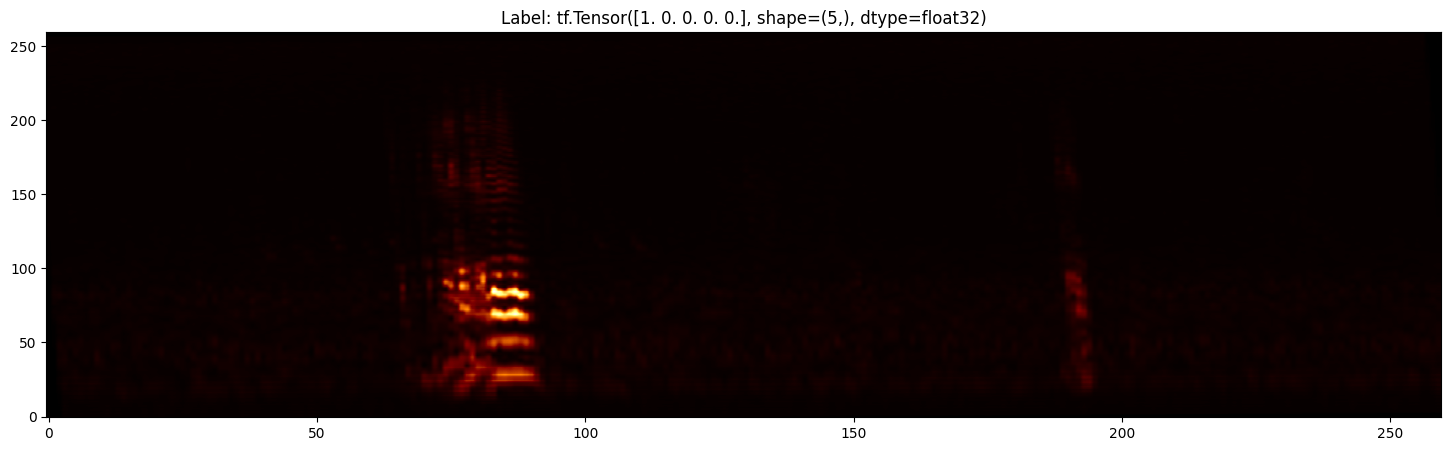

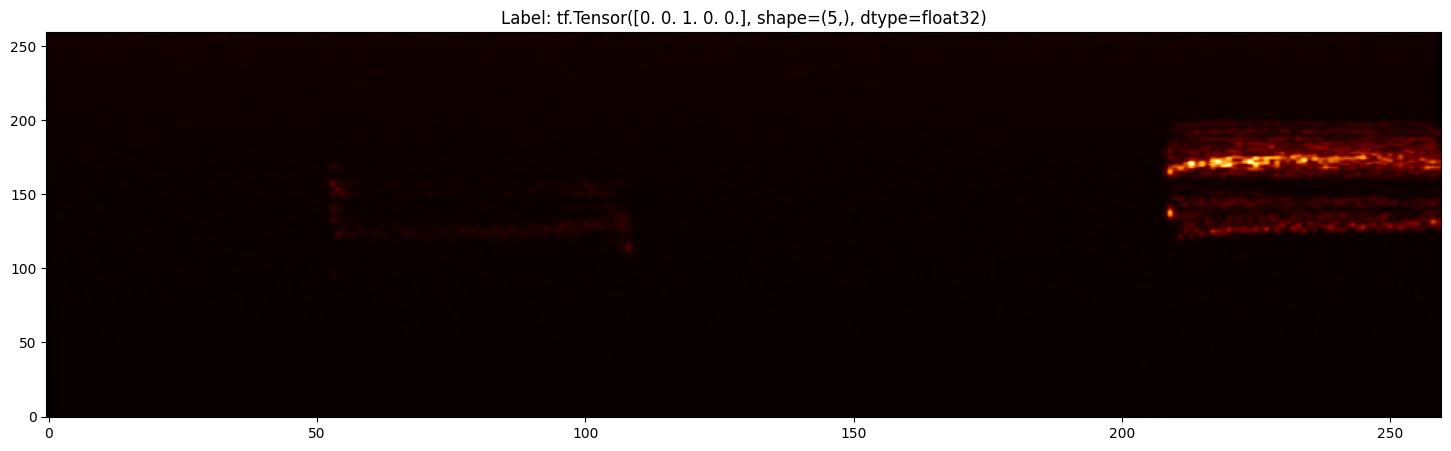

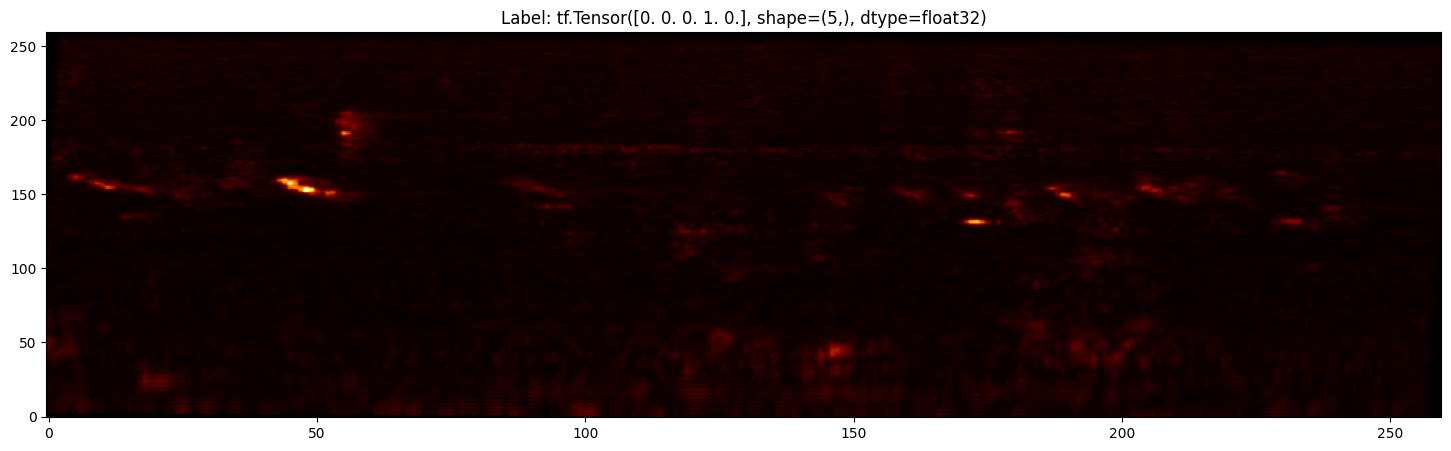

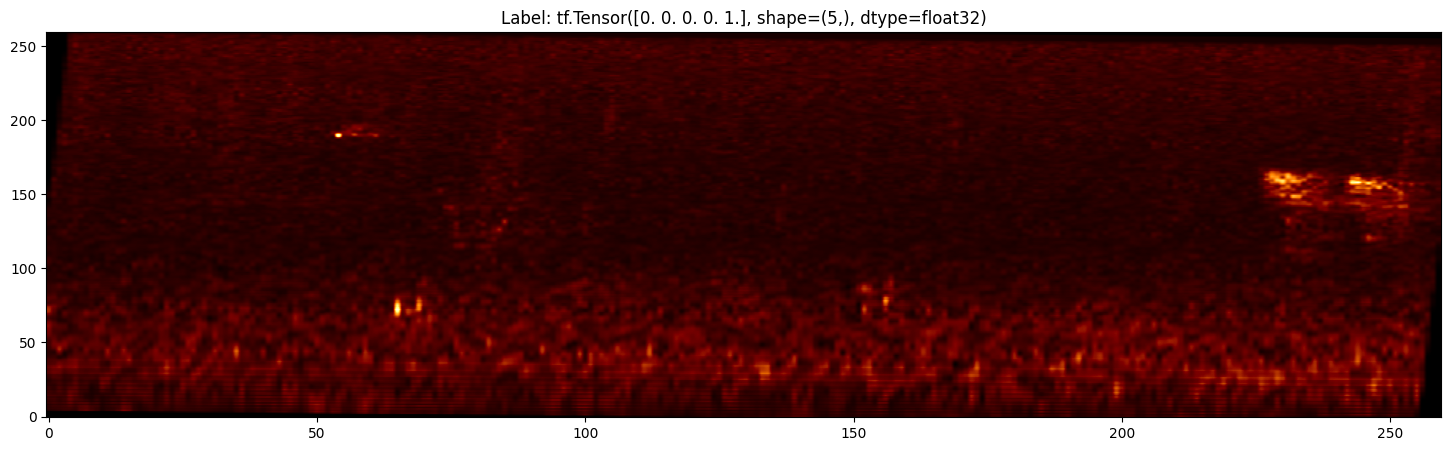

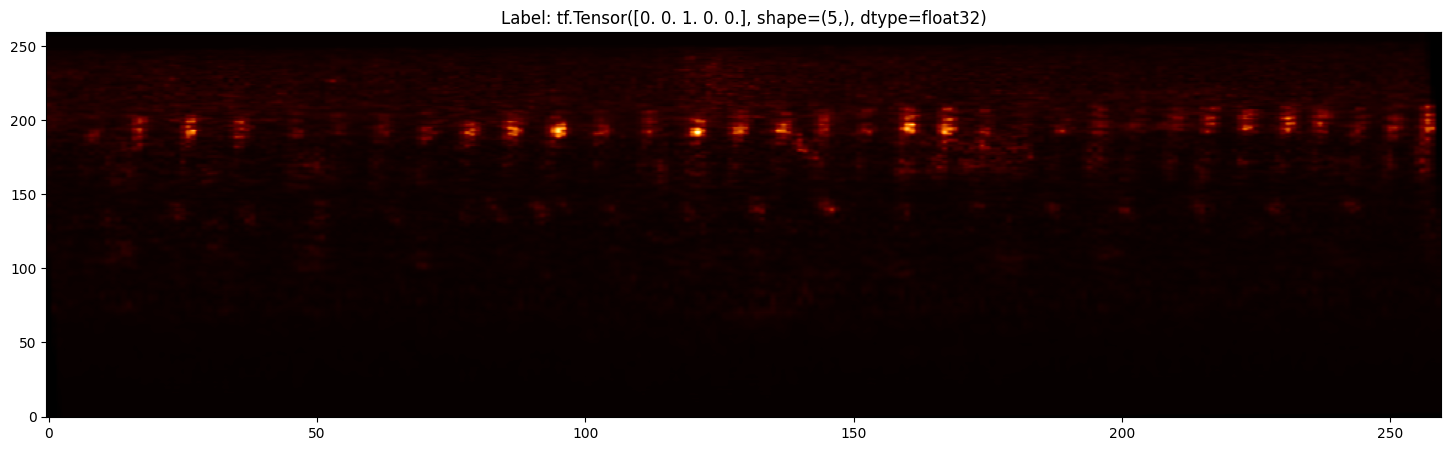

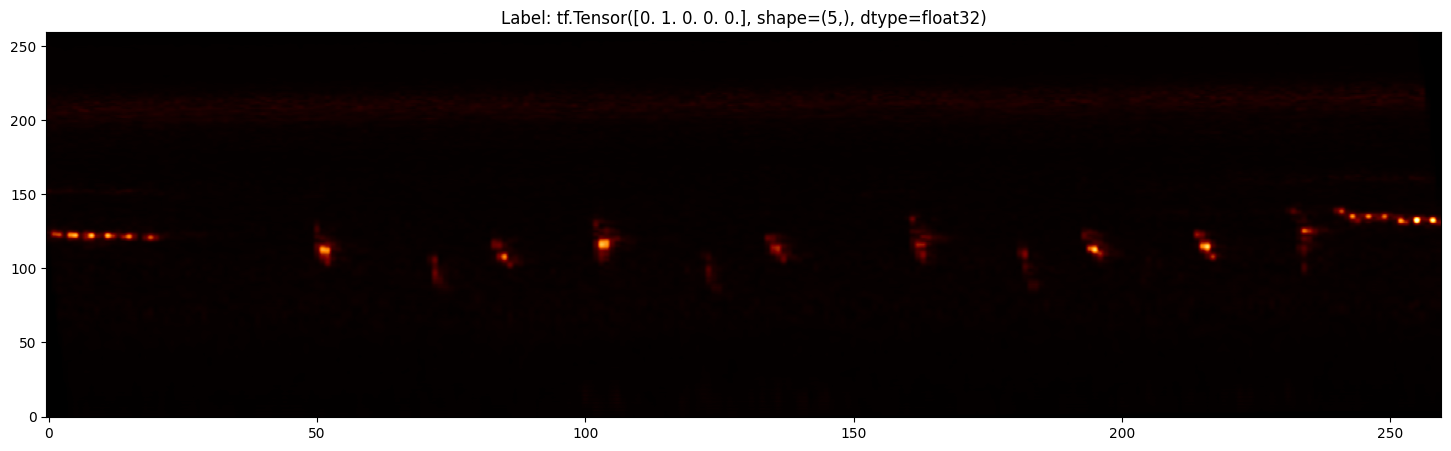

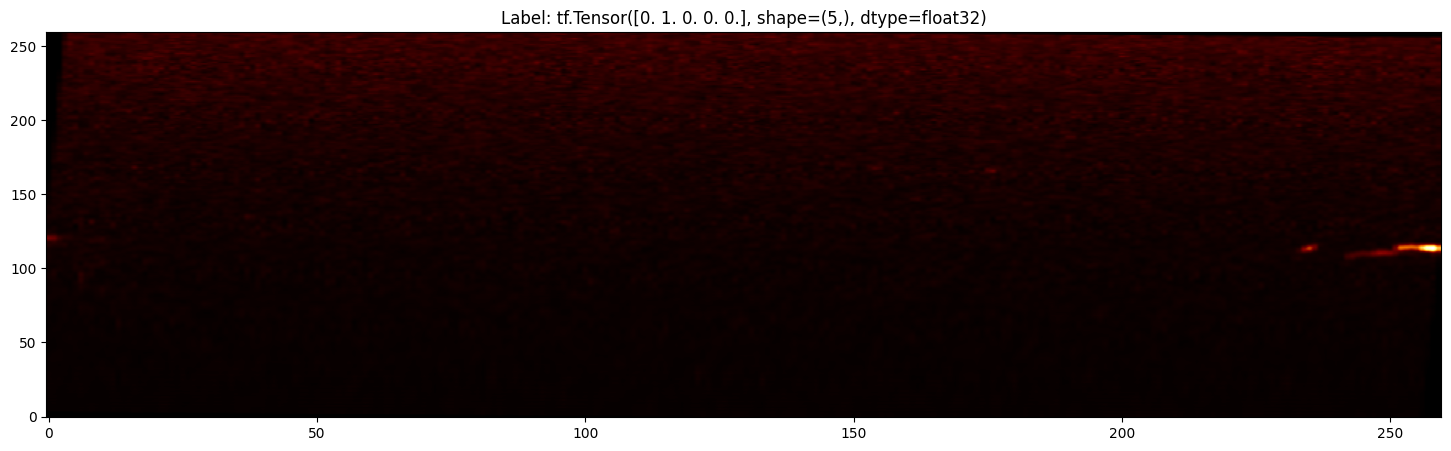

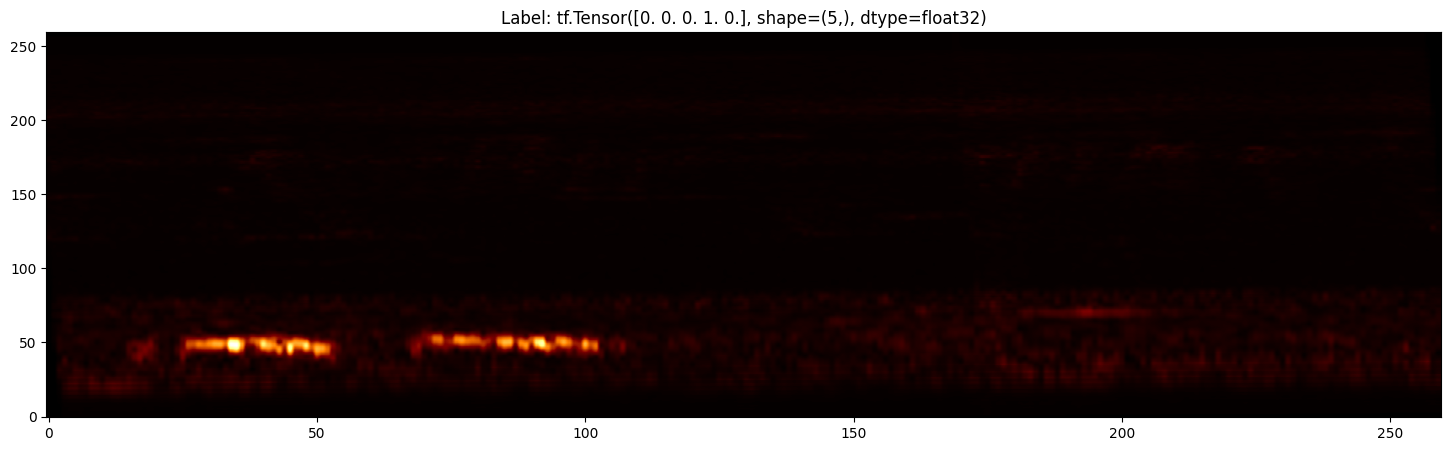

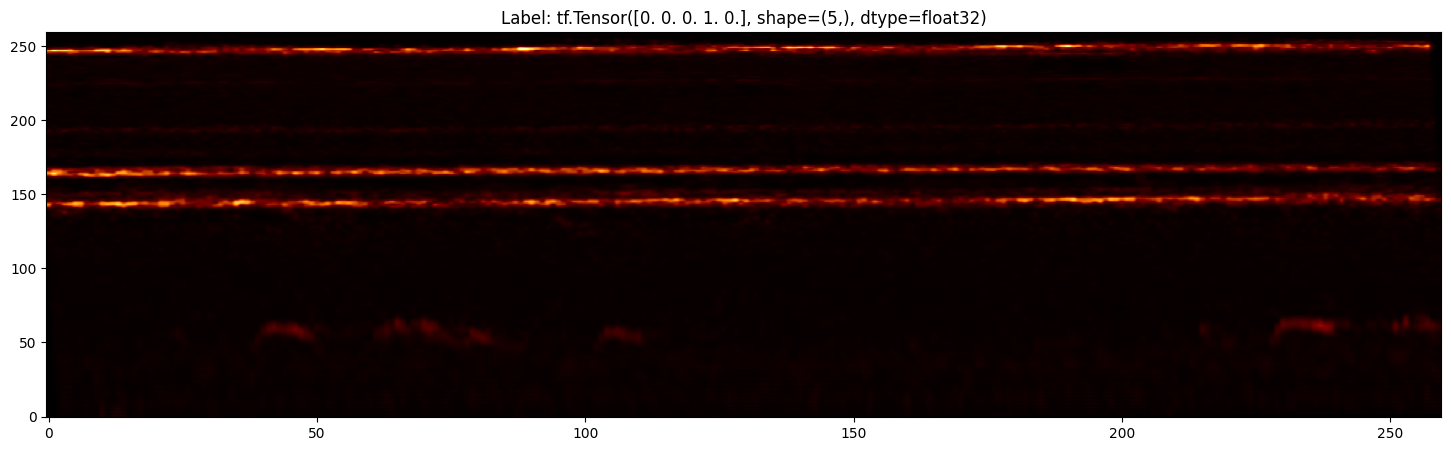

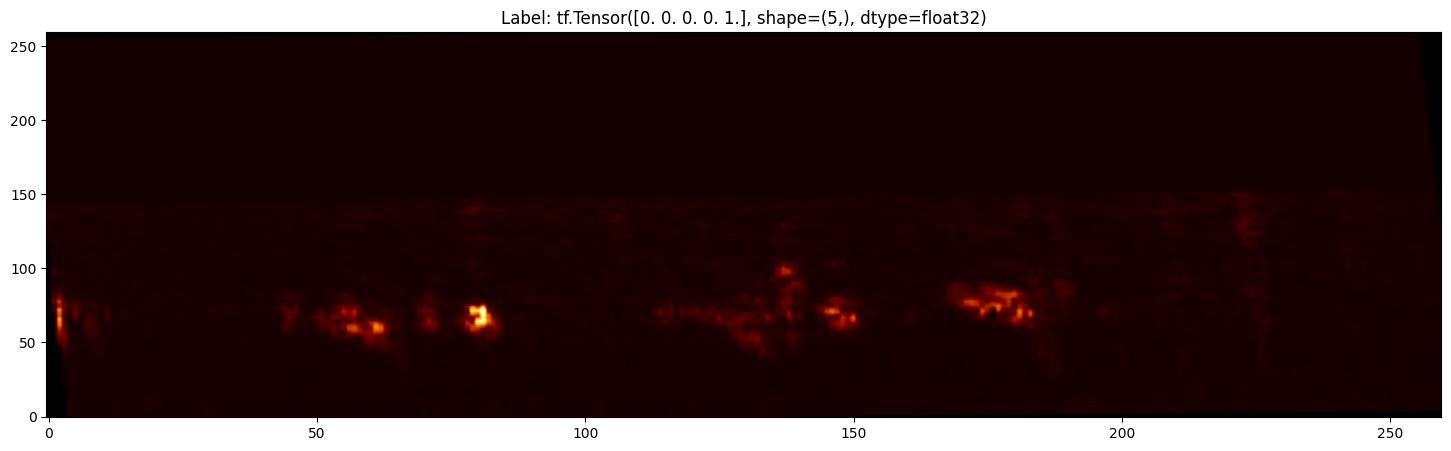

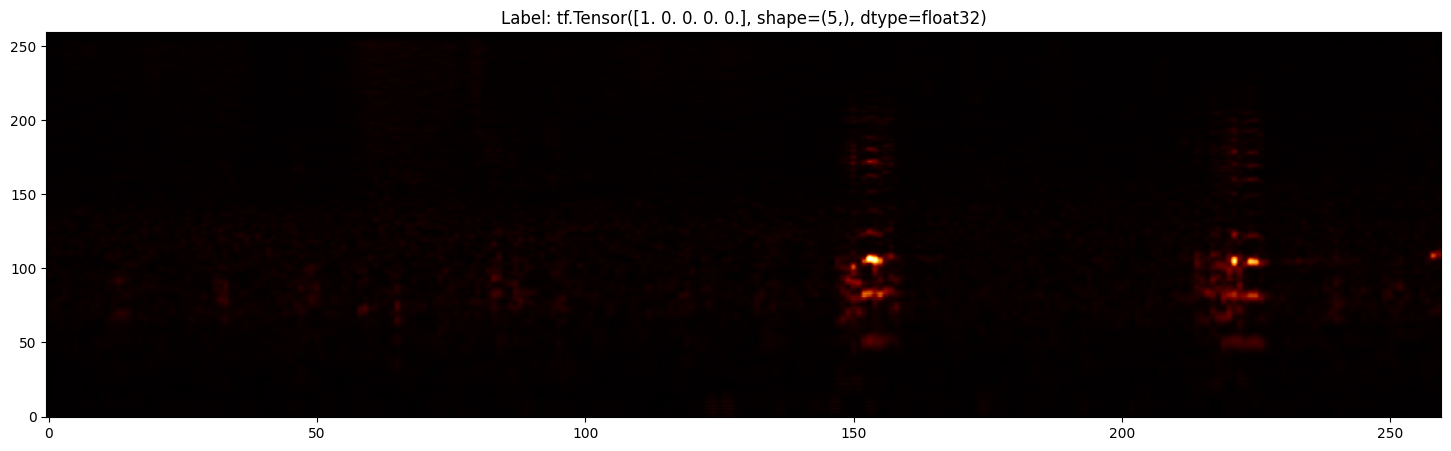

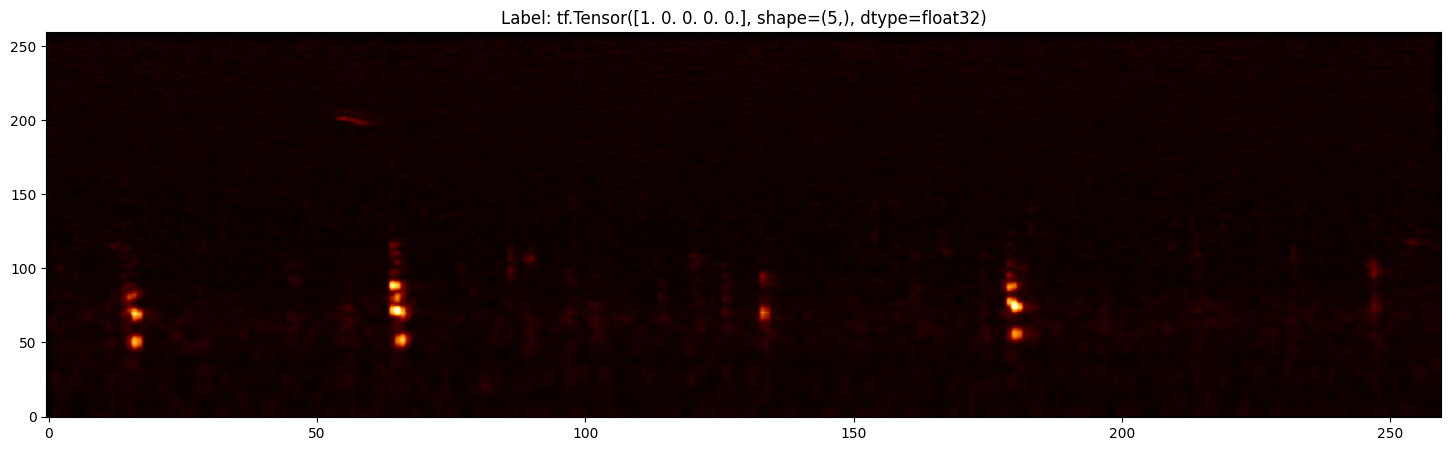

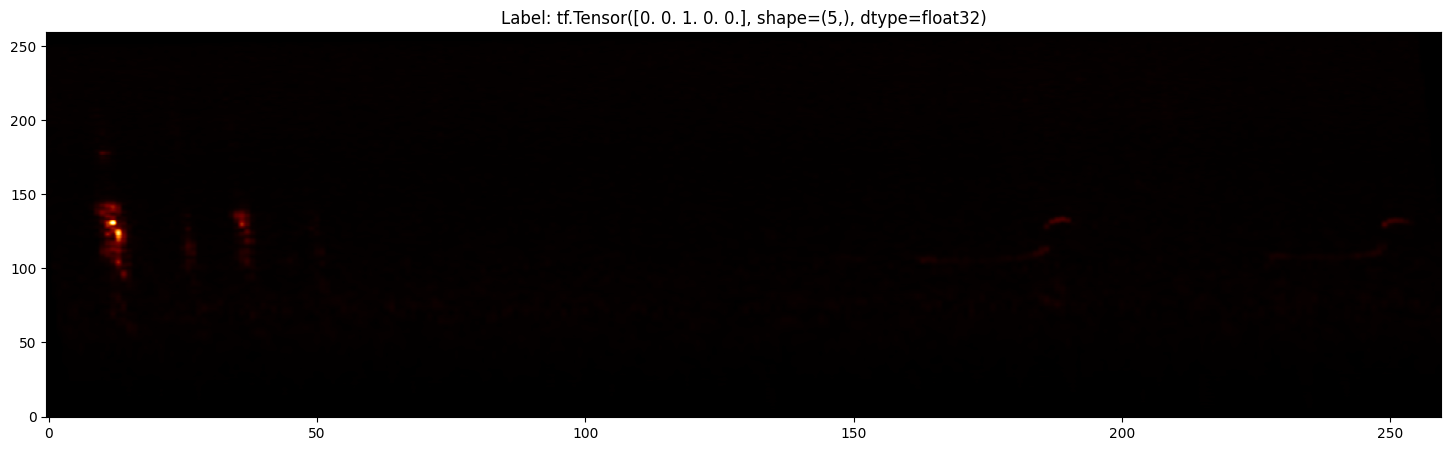

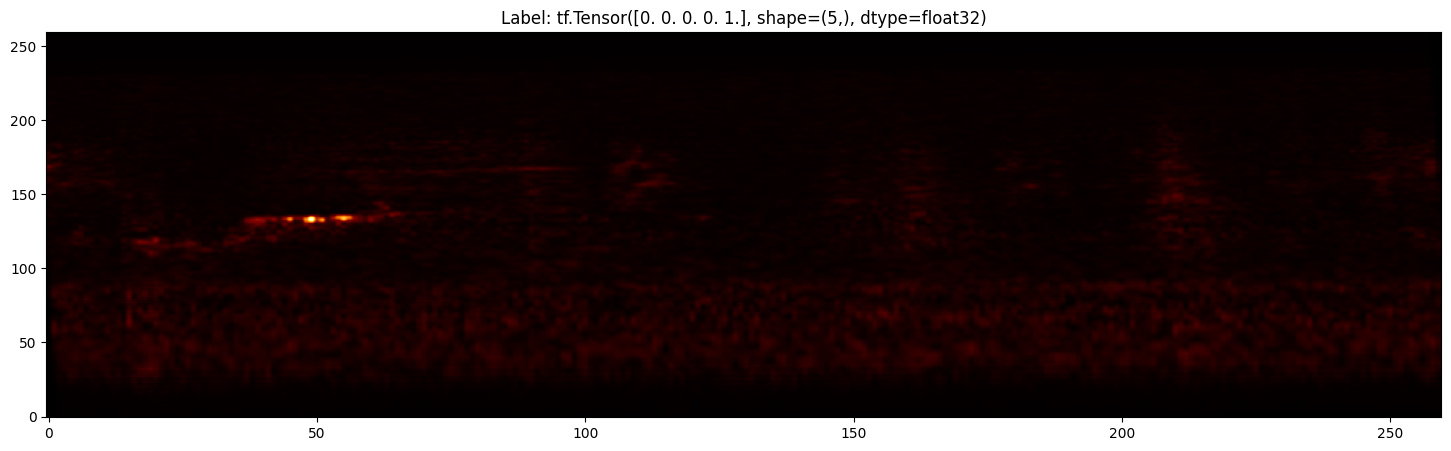

: 

: 

In [ ]:
# show what the pipeline looks like at this stage
for melspectrogram,label in train_dataset.take(1):
    print(f' sample info: {melspectrogram.shape}, \n label info: {label.shape} \n {label}')
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

# Classification Model

In order to test whether the pipeline is working a CNN based image classification model is constructed below.  This model leverages pre-trained model weights for the EfficientNetV2 feature model which generates a vector representation of 1000 floats for each input image.  Note that on first run this model tensorflow hub library will check if model weights are available, and if not, will automatically download them to your computer.  This may take a few minutes the first time this is run.

The output from the EfficientNetV2 model is then fed into 2 fully connected layers to perform the classification function.

In [ ]:
def build_model(trainable):
    # Build a classification model using a pre-trained EfficientNetV2
    model = tf.keras.Sequential(
        [
            # Input layer with specified image dimensions
            tf.keras.layers.InputLayer(input_shape=(SC['MODEL_INPUT_IMAGE_HEIGHT'], 
                                                    SC['MODEL_INPUT_IMAGE_WIDTH'], 
                                                    SC['MODEL_INPUT_IMAGE_CHANNELS'])),

            # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
            hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2", trainable),

            # Add the classification layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),

            # Fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 8,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Another fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 4,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Add dropout to reduce overfitting
            tf.keras.layers.Dropout(0.50),

            # Output layer with one node per class, without activation
            tf.keras.layers.Dense(len(class_names), activation=None),
        ]
    )
    # Set the input shape for the model
    model.build([None, 
                 SC['MODEL_INPUT_IMAGE_HEIGHT'],
                 SC['MODEL_INPUT_IMAGE_WIDTH'], 
                 SC['MODEL_INPUT_IMAGE_CHANNELS']])

    # Display the model summary
    model.summary()

    return model

: 

: 

# Model Training

The following sets up callbacks to track model training and performs the model fit to train the model.

The callbacks will ensure the best model weights (as defined by lowest validation loss) will be written to disk during training.  This is important as the model training could take several hours (12+ hours) to complete and any errors may cause the training loop to exit - so having the checkpoints acts as a backup.  The model will stop training when it sees no further improvement to the validation loss, after which it will restore the best weights found.  This allows the training to discover when it is overfit and stop further training.  This is why the number of epics is 10000.  It is expected the model training will end significantly earlier than this.

In [ ]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
# allow all the weights to be trained
model = build_model(True)

# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.75,
                                                      patience=8, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-7)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=16,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.hdf5', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# any changes to the source code will generally require the disk cache to be cleared.
# So to be safe, the cache is cleared before training the model.  If you are sure
# the cache is still valid then comment out this code
# the first few epochs of the model training will be slow as the cache is populated with pipeline samples
# and will depend on the dataset size and the number of variants included
if SC['USE_DISK_CACHE']:
    cache.clear()

# fit the model to the training set
# this may take 12-24 hours to run to full model convergence depending on your machine
model.fit(train_dataset, 
          validation_data=validation_dataset,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=10000)      

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              7200312   
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 40)                40040     
                                                                 
 batch_normalization_1 (Batc  (None, 40)               160       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 20)                8

2023-04-25 20:45:01.871387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [524]
	 [[{{node Placeholder/_2}}]]
2023-04-25 20:45:01.871642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [524]
	 [[{{node Placeholder/_2}}]]
2023-04-25 20:45:02.459155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/head/StatefulPartitionedCall_grad/head/Stat

UnimplementedError: Graph execution error:

DNN library is not found.
	 [[{{node conv2d/Conv2D}}]] [Op:__inference_train_function_69136]

: 

: 

# Model Predictions on test data

The following provides an example of how to use the trained model to perform inference (predictions).  It calculates the best class and the probability for that class.

In [ ]:
# Function to predict class and probability given a prediction
def predict_class(predictions):
    # Get the index of the class with the highest predicted probability
    predicted_index = int(tf.argmax(tf.squeeze(predictions)).numpy())
    # Get the class name using the predicted index
    predicted_class = class_names[predicted_index]
    # Calculate the predicted probability for the selected class
    predicted_probability = 100.0 * tf.nn.softmax(predictions)[predicted_index].numpy()
    # Round the probability to 2 decimal places
    predicted_probability = str(round(predicted_probability, 2))
    return predicted_class, predicted_probability

# Display class names and run prediction on test entries
print(f'Class names: {class_names}')
for features, labels in test_dataset:
    # Generate predictions for the given features
    predictions = model.predict(features, verbose=0)

    # Iterate over each item in the batch
    for batch_idx in range(predictions.shape[0]):
        # Get the index of the true class
        true_index = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        # Get the true class name using the true index
        true_class = class_names[true_index]

        # Predict class and probability using the prediction function
        predicted_class, predicted_probability = predict_class(predictions[batch_idx])

        print(f'True class      : {true_class}')
        print(f'Predicted class : {predicted_class}')
        print(f'Predicted probability : {predicted_probability}')

: 

: 

In [ ]:
# Save the model weights
model.save_weights('models/generic_engine_pipeline_model.hdf5', save_format='h5')

# Build a new model for testing (inference)
test_model = build_model(False)
# Set the input shape for the test model
test_model.build([None, 
                  SC['MODEL_INPUT_IMAGE_HEIGHT'],
                  SC['MODEL_INPUT_IMAGE_WIDTH'], 
                  SC['MODEL_INPUT_IMAGE_CHANNELS']])
# Load the saved weights into the test model
test_model.load_weights('models/generic_engine_pipeline_model.hdf5')

: 

: 

In [ ]:
# Build a new model for testing (inference)
test_model = build_model(False)
# Set the input shape for the test model
test_model.build([None, 
                  SC['MODEL_INPUT_IMAGE_HEIGHT'],
                  SC['MODEL_INPUT_IMAGE_WIDTH'], 
                  SC['MODEL_INPUT_IMAGE_CHANNELS']])
# Load the saved weights into the test model
test_model.load_weights('models/generic_engine_pipeline_model.hdf5')

# Save the full model for use with tensorflow serving
model.save('models/generic_engine_pipeline_model/1', overwrite=True)

: 

: 

In [ ]:
# dataset logic test to look for data leakage
def test_code():
    data = [1,2,3,4,5,6,7,8,9,10]

    dataset = tf.data.Dataset.from_tensor_slices(data)

    # dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=False)

    # Calculate the size of the dataset
    dataset_size = len(dataset)

    # Calculate the number of elements for each dataset split
    train_size = int(0.5 * dataset_size)
    val_size = int(0.4 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size).take(test_size)

    # Create the training dataset pipeline
    train_dataset = (train_ds
                    .shuffle(len(train_ds))
                    .repeat(count=2)
    )

    for x in train_ds:
        print(f'train_ds {x}')
        
    for x in val_ds:
        print(f'val_ds {x}')    
        
    for x in test_ds:
        print(f'test_ds {x}')    
        
    for x in train_dataset:
        print(f'train_dataset {x}') 
        
test_code()

: 

: 